## CQR raw, self implemented

In [ ]:
import numpy as np
from lightgbm import LGBMRegressor
from typing import Tuple, Optional, Union
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt

In [2]:
def monotonize_curves(
    y_pred_lower: ArrayLike,
    y_pred_upper: ArrayLike,
) -> Tuple[NDArray, NDArray]:
    """
    Monotonize curves from arbitrary quantile regression model.

    Swap lower and upper predictions if the former is greater than the latter
    to build a proper interval.

    Parameters:
    -----------
    y_pred_lower : array-like
        Lower bound predictions
    y_pred_upper : array-like
        Upper bound predictions

    Returns:
    --------
    tuple
        Corrected (lower, upper) prediction arrays
    """
    if (y_pred_lower > y_pred_upper).any():
        y_preds = np.array([y_pred_lower, y_pred_upper]).T
        y_preds = np.sort(y_preds, axis=1)
        y_pred_lower, y_pred_upper = y_preds[:, 0], y_preds[:, 1]
    return y_pred_lower, y_pred_upper

In [3]:
def fit_gradient_boosting_qr(
    X: ArrayLike,
    y: ArrayLike,
    alpha: float = 0.1,
    seed: Optional[int] = None,
    params: Optional[dict] = None
) -> Tuple[LGBMRegressor, LGBMRegressor]:
    """
    Train LightGBM quantile regression models for lower and upper bounds.
    
    Parameters:
    -----------
    X : array-like
        Training features
    y : array-like
        Target values
    alpha : float, default=0.1
        Desired miscoverage level (e.g., 0.1 for 90% prediction interval)
    seed : int, optional
        Random seed for reproducibility
    params : dict, optional
        Additional parameters for LGBMRegressor
        
    Returns:
    --------
    tuple
        Trained (lower_model, upper_model)
    """
    default_params = {
        "objective": "quantile",
        "metric": "quantile",
        "boosting_type": "gbdt",
        "deterministic": True,
        "force_row_wise": True,
        "seed": seed,
    }
    
    if params is not None:
        default_params.update(params)
    
    # Create and fit lower quantile model
    lower_params = default_params.copy()
    lower_params["alpha"] = alpha / 2
    qr_lower = LGBMRegressor(**lower_params).fit(X, y)
    
    # Create and fit upper quantile model
    upper_params = default_params.copy()
    upper_params["alpha"] = 1 - alpha / 2
    qr_upper = LGBMRegressor(**upper_params).fit(X, y)
    
    return qr_lower, qr_upper

In [4]:
def predict_gradient_boosting_qr(
    X: ArrayLike,
    lower_model: LGBMRegressor,
    upper_model: LGBMRegressor
) -> Tuple[NDArray, NDArray]:
    """
    Generate prediction intervals using trained quantile regression models.
    
    Parameters:
    -----------
    X : array-like
        Features to predict on
    lower_model : LGBMRegressor
        Model trained for lower bound prediction
    upper_model : LGBMRegressor
        Model trained for upper bound prediction
    
    Returns:
    --------
    tuple
        (lower_bounds, upper_bounds) predictions
    """
    y_pred_lower = lower_model.predict(X)
    y_pred_upper = upper_model.predict(X)
    return monotonize_curves(y_pred_lower, y_pred_upper)


In [5]:
def fit_conformal_qr(
    X_train: ArrayLike,
    y_train: ArrayLike,
    X_calib: ArrayLike,
    y_calib: ArrayLike,
    alpha: float = 0.1,
    seed: Optional[int] = None,
    params: Optional[dict] = None
) -> Tuple[LGBMRegressor, LGBMRegressor, float]:
    """
    Train and calibrate a conformalized quantile regression model.
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training target values
    X_calib : array-like
        Calibration features
    y_calib : array-like
        Calibration target values
    alpha : float, default=0.1
        Desired miscoverage level (e.g., 0.1 for 90% prediction interval)
    seed : int, optional
        Random seed for reproducibility
    params : dict, optional
        Additional parameters for LGBMRegressor
        
    Returns:
    --------
    tuple
        (lower_model, upper_model, conformity_score)
    """
    # Train base quantile regression models
    qr_lower, qr_upper = fit_gradient_boosting_qr(X_train, y_train, alpha, seed, params)
    
    # Calculate calibration scores
    y_pred_lower, y_pred_upper = predict_gradient_boosting_qr(X_calib, qr_lower, qr_upper)
    scores = np.maximum(y_pred_lower - y_calib, y_calib - y_pred_upper)
    q_hat = np.quantile(scores, 1 - alpha)
    
    return qr_lower, qr_upper, q_hat


In [6]:
def predict_conformal_qr(
    X: ArrayLike,
    lower_model: LGBMRegressor,
    upper_model: LGBMRegressor,
    q_hat: float
) -> Tuple[NDArray, NDArray]:
    """
    Generate conformalized prediction intervals.
    
    Parameters:
    -----------
    X : array-like
        Features to predict on
    lower_model : LGBMRegressor
        Model trained for lower bound prediction
    upper_model : LGBMRegressor
        Model trained for upper bound prediction
    q_hat : float
        Conformity score from calibration
        
    Returns:
    --------
    tuple
        (lower_bounds, upper_bounds) conformalized predictions
    """
    # Generate base predictions
    y_pred_lower, y_pred_upper = predict_gradient_boosting_qr(X, lower_model, upper_model)
    
    # Conformalize predictions
    y_pred_lower = y_pred_lower - q_hat
    y_pred_upper = y_pred_upper + q_hat
    
    return monotonize_curves(y_pred_lower, y_pred_upper)


In [7]:
def empirical_coverage(
    y_test: ArrayLike,
    y_pred_lower: ArrayLike,
    y_pred_upper: ArrayLike,
) -> float:
    """Calculate average number of times that realized values fell inside prediction intervals."""
    # Ensure data type is numpy array
    y_test = np.asarray(y_test)
    y_pred_lower = np.asarray(y_pred_lower)
    y_pred_upper = np.asarray(y_pred_upper)

    if not (y_pred_upper >= y_pred_lower).all():
        raise ValueError("There is an upper bound strictly smaller than a lower bound.")

    empirical_coverage = ((y_test >= y_pred_lower) * (y_test <= y_pred_upper)).mean().item()

    assert isinstance(empirical_coverage, float)

    return empirical_coverage

In [8]:
def average_interval_size(
    y_pred_lower: ArrayLike,
    y_pred_upper: ArrayLike,
) -> float:
    """Calculate average size of prediction intervals."""
    # Ensure data type is numpy array
    y_pred_lower = np.asarray(y_pred_lower)
    y_pred_upper = np.asarray(y_pred_upper)

    if not (y_pred_upper >= y_pred_lower).all():
        raise ValueError("Upper bounds should be larger than or equal to lower bounds.")

    average_interval_size = (y_pred_upper - y_pred_lower).mean().item()

    assert isinstance(average_interval_size, float)

    return average_interval_size

In [9]:
def coverage_mean_absolute_error(
    theoretical_coverage: float,
    empirical_coverages: ArrayLike,
) -> float:
    """Calculate mean absolute error between empirical coverages and theoretical value."""
    empirical_coverages = np.asarray(empirical_coverages)
    coverage_mae = np.abs(empirical_coverages - theoretical_coverage).mean().item()
    assert isinstance(coverage_mae, float)
    return coverage_mae

In [10]:
def coverage_mean_square_error(
    theoretical_coverage: float,
    empirical_coverages: ArrayLike,
) -> float:
    """Calculate mean squared error between empirical coverages and theoretical value."""
    empirical_coverages = np.asarray(empirical_coverages)
    coverage_mse = ((empirical_coverages - theoretical_coverage) ** 2).mean().item()
    assert isinstance(coverage_mse, float)
    return coverage_mse

In [11]:
def plot_prediction_intervals(y_true, lower_bounds, upper_bounds, method_name, ax=None):
    """
    Plot prediction intervals against true values.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    lower_bounds : array-like
        Lower bounds of prediction intervals
    upper_bounds : array-like
        Upper bounds of prediction intervals
    method_name : str
        Name of the method for the plot title
    ax : matplotlib.axes, optional
        Axes to plot on. If None, creates a new figure
        
    Returns:
    --------
    matplotlib.axes
        The axes with the plot
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    # Sort all arrays by true values for better visualization
    sorted_indices = np.argsort(y_true)
    y_true_sorted = np.array(y_true)[sorted_indices]
    lower_sorted = np.array(lower_bounds)[sorted_indices]
    upper_sorted = np.array(upper_bounds)[sorted_indices]
    
    # Plot data points
    x = np.arange(len(y_true_sorted))
    ax.scatter(x, y_true_sorted, color='black', s=10, alpha=0.7, label='True values')
    
    # Plot prediction intervals
    ax.fill_between(x, lower_sorted, upper_sorted, color='blue', alpha=0.3, label='Prediction interval')
    
    # Plot interval bounds
    ax.plot(x, lower_sorted, 'b--', linewidth=0.5, alpha=0.7)
    ax.plot(x, upper_sorted, 'b--', linewidth=0.5, alpha=0.7)
    
    # Calculate interval coverage
    coverage = np.mean((y_true_sorted >= lower_sorted) & (y_true_sorted <= upper_sorted)) * 100
    interval_width = np.mean(upper_sorted - lower_sorted)
    
    ax.set_title(f'{method_name} - Coverage: {coverage:.1f}%, Avg Width: {interval_width:.3f}')
    ax.set_xlabel('Sample index (sorted by true value)')
    ax.set_ylabel('Target value')
    ax.legend()
    
    return ax

def plot_comparison(y_true, y_pred_regular, lower_bounds, upper_bounds, 
                   lower_bounds_conf, upper_bounds_conf):
    """
    Plot comparison between regular and conformalized quantile regression.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred_regular : array-like
        Point predictions (optional, can be None)
    lower_bounds : array-like
        Lower bounds from regular quantile regression
    upper_bounds : array-like
        Upper bounds from regular quantile regression
    lower_bounds_conf : array-like
        Lower bounds from conformalized quantile regression
    upper_bounds_conf : array-like
        Upper bounds from conformalized quantile regression
    
    Returns:
    --------
    matplotlib.figure
        Figure with the comparison plots
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot regular quantile regression
    plot_prediction_intervals(y_true, lower_bounds, upper_bounds, 
                             "Regular Quantile Regression", axes[0])
    
    # Plot conformalized quantile regression
    plot_prediction_intervals(y_true, lower_bounds_conf, upper_bounds_conf, 
                             "Conformalized Quantile Regression", axes[1])
    
    plt.tight_layout()
    return fig

def evaluate_prediction_intervals(y_true, lower_bounds, upper_bounds, method_name="Method"):
    """
    Evaluate prediction intervals with various metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    lower_bounds : array-like
        Lower bounds of prediction intervals
    upper_bounds : array-like
        Upper bounds of prediction intervals
    method_name : str, optional
        Name of the method for printing
    
    Returns:
    --------
    dict
        Dictionary with evaluation metrics
    """
    # Calculate coverage (percentage of true values within the interval)
    in_interval = (y_true >= lower_bounds) & (y_true <= upper_bounds)
    coverage = np.mean(in_interval) * 100
    
    # Calculate average interval width
    interval_width = np.mean(upper_bounds - lower_bounds)
    
    # Calculate mean interval score (sharpness)
    alpha = 0.1  # Assuming 90% prediction intervals
    below = y_true < lower_bounds
    above = y_true > upper_bounds
    interval_score = (upper_bounds - lower_bounds) + \
                     (2/alpha) * (lower_bounds - y_true) * below + \
                     (2/alpha) * (y_true - upper_bounds) * above
    mean_interval_score = np.mean(interval_score)
    
    # Print results
    print(f"\n--- {method_name} Evaluation ---")
    print(f"Coverage: {coverage:.2f}% (target: {(1-alpha)*100:.1f}%)")
    print(f"Average interval width: {interval_width:.4f}")
    print(f"Mean interval score (lower is better): {mean_interval_score:.4f}")
    
    # Return metrics as dictionary
    return {
        "coverage": coverage,
        "width": interval_width,
        "interval_score": mean_interval_score
    }

C:\Users\xkorpijo3\OneDrive - Fortum\Desktop\Master-thesis-GBRT-dam
Split index val: 28107
Split index test: 32122
Training set size: 28107 (h)
Validation set size: 4015 (h)
Test set size: 8031 (h)
Dataset length: 40153
[LightGBM] [Info] Total Bins 7086
[LightGBM] [Info] Number of data points in the train set: 28107, number of used features: 32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

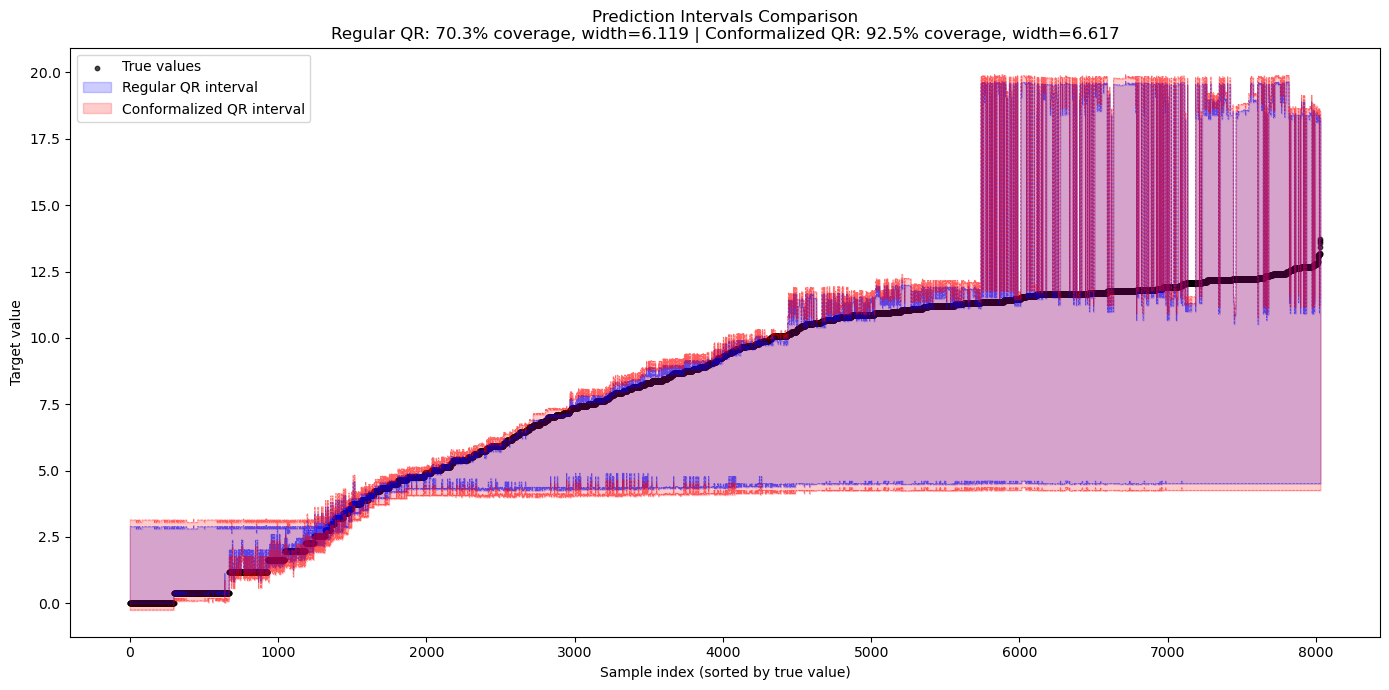

In [ ]:
def plot_combined_intervals(y_true, lower_bounds, upper_bounds, 
                           lower_bounds_conf, upper_bounds_conf,
                           title="Prediction Intervals Comparison",
                           figsize=(14, 7)):
    """
    Plot regular and conformalized prediction intervals on the same graph.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    lower_bounds : array-like
        Lower bounds from regular quantile regression
    upper_bounds : array-like
        Upper bounds from regular quantile regression
    lower_bounds_conf : array-like
        Lower bounds from conformalized quantile regression
    upper_bounds_conf : array-like
        Upper bounds from conformalized quantile regression
    title : str, optional
        Plot title
    figsize : tuple, optional
        Figure size
        
    Returns:
    --------
    matplotlib.figure
        Figure with the plot
    """
    # Sort all arrays by true values for better visualization
    sorted_indices = np.argsort(y_true)
    y_true_sorted = np.array(y_true)[sorted_indices]
    lower_sorted = np.array(lower_bounds)[sorted_indices]
    upper_sorted = np.array(upper_bounds)[sorted_indices]
    lower_conf_sorted = np.array(lower_bounds_conf)[sorted_indices]
    upper_conf_sorted = np.array(upper_bounds_conf)[sorted_indices]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    x = np.arange(len(y_true_sorted))
    
    # Plot true values
    ax.scatter(x, y_true_sorted, color='black', s=10, alpha=0.7, label='True values')
    
    # Plot regular quantile regression intervals
    ax.fill_between(x, lower_sorted, upper_sorted, color='blue', alpha=0.2, 
                   label='Regular QR interval')
    ax.plot(x, lower_sorted, 'b--', linewidth=0.5, alpha=0.5)
    ax.plot(x, upper_sorted, 'b--', linewidth=0.5, alpha=0.5)
    
    # Plot conformalized quantile regression intervals
    ax.fill_between(x, lower_conf_sorted, upper_conf_sorted, color='red', alpha=0.2, 
                   label='Conformalized QR interval')
    ax.plot(x, lower_conf_sorted, 'r--', linewidth=0.5, alpha=0.5)
    ax.plot(x, upper_conf_sorted, 'r--', linewidth=0.5, alpha=0.5)
    
    # Calculate metrics for each method
    qr_coverage = np.mean((y_true_sorted >= lower_sorted) & 
                         (y_true_sorted <= upper_sorted)) * 100
    qr_width = np.mean(upper_sorted - lower_sorted)
    
    cqr_coverage = np.mean((y_true_sorted >= lower_conf_sorted) & 
                          (y_true_sorted <= upper_conf_sorted)) * 100
    cqr_width = np.mean(upper_conf_sorted - lower_conf_sorted)
    
    # Set title and labels
    ax.set_title(f"{title}\nRegular QR: {qr_coverage:.1f}% coverage, width={qr_width:.3f} | "
                f"Conformalized QR: {cqr_coverage:.1f}% coverage, width={cqr_width:.3f}")
    ax.set_xlabel('Sample index (sorted by true value)')
    ax.set_ylabel('Target value')
    ax.legend()
    
    plt.tight_layout()
    return fig

def plot_with_zoom(y_true, lower_bounds, upper_bounds, 
                  lower_bounds_conf, upper_bounds_conf,
                  zoom_range=(0, 50), # Show first 50 samples in zoom
                  figsize=(14, 10)):
    """
    Plot combined intervals with a zoomed-in region for better detail.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    lower_bounds, upper_bounds : array-like
        Regular QR bounds
    lower_bounds_conf, upper_bounds_conf : array-like
        Conformalized QR bounds
    zoom_range : tuple, optional
        Range of indices to zoom in on (start, end)
    figsize : tuple, optional
        Figure size
        
    Returns:
    --------
    matplotlib.figure
        Figure with the plots
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Sort all arrays
    sorted_indices = np.argsort(y_true)
    y_true_sorted = np.array(y_true)[sorted_indices]
    lower_sorted = np.array(lower_bounds)[sorted_indices]
    upper_sorted = np.array(upper_bounds)[sorted_indices]
    lower_conf_sorted = np.array(lower_bounds_conf)[sorted_indices]
    upper_conf_sorted = np.array(upper_bounds_conf)[sorted_indices]
    
    # Plot full data
    x = np.arange(len(y_true_sorted))
    ax1.scatter(x, y_true_sorted, color='black', s=10, alpha=0.7, label='True values')
    ax1.fill_between(x, lower_sorted, upper_sorted, color='blue', alpha=0.2, 
                    label='Regular QR interval')
    ax1.fill_between(x, lower_conf_sorted, upper_conf_sorted, color='red', alpha=0.2, 
                    label='Conformalized QR interval')
    ax1.set_title("Full dataset comparison")
    ax1.set_xlabel('Sample index (sorted by true value)')
    ax1.set_ylabel('Target value')
    ax1.legend()
    
    # Plot zoomed-in region
    start, end = zoom_range
    x_zoom = x[start:end]
    ax2.scatter(x_zoom, y_true_sorted[start:end], color='black', s=20, alpha=0.7, label='True values')
    
    # Regular QR
    ax2.fill_between(x_zoom, lower_sorted[start:end], upper_sorted[start:end], 
                    color='blue', alpha=0.2, label='Regular QR interval')
    ax2.plot(x_zoom, lower_sorted[start:end], 'b--', linewidth=1, alpha=0.7)
    ax2.plot(x_zoom, upper_sorted[start:end], 'b--', linewidth=1, alpha=0.7)
    
    # Conformalized QR
    ax2.fill_between(x_zoom, lower_conf_sorted[start:end], upper_conf_sorted[start:end], 
                    color='red', alpha=0.2, label='Conformalized QR interval')
    ax2.plot(x_zoom, lower_conf_sorted[start:end], 'r--', linewidth=1, alpha=0.7)
    ax2.plot(x_zoom, upper_conf_sorted[start:end], 'r--', linewidth=1, alpha=0.7)
    
    ax2.set_title(f"Zoomed view (samples {start}-{end})")
    ax2.set_xlabel('Sample index (sorted by true value)')
    ax2.set_ylabel('Target value')
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    

    import os
    from pathlib import Path
    if os.getcwd()=='C:/Users/xkorpijo3/OneDrive - Fortum/Desktop/Master-thesis-GBRT-dam':
        root_dir = Path(os.getcwd()).resolve().parent
        os.chdir(root_dir)
    print(os.getcwd())
    from utils.data_preparation import preprocess_data, split_data_validation, mapping

    features = ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18',
                'h', 'h_MA_007', 'h_MA_014', 'h_MA_030', 'h_MA_060', 'h_RC_007', 'h_RC_030',
                'P', 'P_RS_030', 'P_RS_060', 'P_RS_090', 'P_RS_180',
                'T', 'T_MA_001', 'T_MA_007', 'T_MA_030', 'T_MA_060',
                't', 'ln_t', 'Cos_s', 'Sin_s', 'Cos_2s', 'Sin_2s', 'month', 'year']
    target = 'MB18'
    poly_degree = 4
    start_date = "08-01-2020"
    end_date = "03-01-2025"
    validation_size = 0.1
    test_size = 0.2

    X, y, dates = preprocess_data(features, target, start_date, end_date, poly_degree=poly_degree, \
                                test_size=test_size, validation_size=validation_size)
        
    X_train, X_val, X_test, y_train, y_val, y_test, split_idx_validation, split_idx_test = split_data_validation(X, y, test_size=test_size, validation_size=validation_size)
    print(f"Split index val: {split_idx_validation}")
    print(f"Split index test: {split_idx_test}")
    print(f"Training set size: {len(X_train)} (h)")
    print(f"Validation set size: {len(X_val)} (h)")
    print(f"Test set size: {len(X_test)} (h)")
    print(f"Dataset length: {len(X)}")

    # Train and calibrate the model (90% prediction interval)
    lower_model, upper_model, q_hat = fit_conformal_qr(
        X_train, y_train, 
        X_val, y_val, 
        alpha=0.1,  # 90% prediction interval
        seed=42
    )

    # Make predictions on new data
    lower_bounds_conf, upper_bounds_conf = predict_conformal_qr(X_test, lower_model, upper_model, q_hat)
    
    # If you just want quantile regression without conformal calibration:
    qr_lower, qr_upper = fit_gradient_boosting_qr(X_train, y_train, alpha=0.1, seed=42)
    lower_bounds, upper_bounds = predict_gradient_boosting_qr(X_test, qr_lower, qr_upper)
    
    # Create combined plot
    fig = plot_combined_intervals(y_test, lower_bounds, upper_bounds, 
                                 lower_bounds_conf, upper_bounds_conf)
    # plt.savefig('combined_intervals.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # # Create plot with zoom
    # fig2 = plot_with_zoom(y_test, lower_bounds, upper_bounds, 
    #                      lower_bounds_conf, upper_bounds_conf,
    #                      zoom_range=(0, 50))
    # plt.savefig('intervals_with_zoom.png', dpi=300, bbox_inches='tight')
    # plt.show()